In [65]:
import lsst.daf.persistence as dafPersist
import matplotlib.pyplot as plt
import numpy as np

import lsst.afw.table as afwTable
import lsst.afw.geom as afwGeom
import Utils.DiaSourceTools as DSTools
from astropy.time import Time

import lsst.afw.display.ds9 as ds9
import lsst.afw.image as afwImage
import re

from multiprocessing import Pool
from functools import partial

import astropy.coordinates as coord
import astropy.units as u

import lsst.daf.base as dafBase
from lsst.meas.algorithms.detection import SourceDetectionTask
from lsst.meas.base import SingleFrameMeasurementTask
from lsst.meas.deblender import SourceDeblendTask

import lsst.afw.math as afwMath

from astropy.table import Table

In [2]:
DATADIR="/datadec/cppm/jpreyes/CFHT_Jointcal"
directory = DATADIR+"/jointcal_testSN_2/"
butler = dafPersist.Butler(directory) 
filter = 'r'


In [3]:
calexp  = butler.get("calexp", dataId={"filter":filter, "visit":849373, "ccd":15})
src = butler.get("src", dataId={"filter":filter, "visit":849373, "ccd":15})

In [69]:
def preConvolve(exposure, sigma=5):
    psf = exposure.getPsf()
    maskedImage = exposure.getMaskedImage()
    kWidth = (int(sigma * 7 + 0.5) // 2) * 2 + 1 # make sure it is odd
    #self.metadata.set("smoothingKernelWidth", kWidth)
    gaussFunc = afwMath.GaussianFunction1D(sigma)
    gaussKernel = afwMath.SeparableKernel(kWidth, kWidth, gaussFunc, gaussFunc)

    convolvedImage = maskedImage.Factory(maskedImage.getBBox())

    afwMath.convolve(convolvedImage, maskedImage, gaussKernel, afwMath.ConvolutionControl())
    #
    # Only search psf-smooth part of frame
    #
    goodBBox = gaussKernel.shrinkBBox(convolvedImage.getBBox())
    middle = convolvedImage.Factory(convolvedImage, goodBBox, afwImage.PARENT, False)
    #
    # Mark the parts of the image outside goodBBox as EDGE
    #
    #self.setEdgeBits(maskedImage, goodBBox, maskedImage.getMask().getPlaneBitMask("EDGE"))
    return convolvedImage

In [4]:
def detect_sources(exposure):
    threshold = 6
    doSmooth=True
    schema = afwTable.SourceTable.makeMinimalSchema()


    algMetadata = dafBase.PropertyList()

    config = SourceDetectionTask.ConfigClass()
    #config.thresholdPolarity = "both"
    config.thresholdValue = threshold
    config.reEstimateBackground = False
    #config.thresholdType = "pixel_stdev"

    detectionTask = SourceDetectionTask(config=config, schema=schema)

    measurement = SingleFrameMeasurementTask
    config = measurement.ConfigClass()

    measurement = measurement(schema, config=config, algMetadata=algMetadata)


    deblend = SourceDeblendTask
    config = SourceDeblendTask.ConfigClass()
    deblend = deblend(schema)

    table = afwTable.SourceTable.make(schema)
    
    results = detectionTask.run(table=table, exposure=exposure , doSmooth=doSmooth )

    sourcesCat = results.sources
    
    deblend.run(exposure, sourcesCat)
    
    

    measurement.run(measCat=sourcesCat, exposure=exposure)

    return sourcesCat

In [65]:


calexp  = butler.get("calexp", dataId={"filter":filter, "visit":849373, "ccd":15})
print calexp.getWcs().getLinearTransform()


[[  5.17978333e-05  -6.73377463e-09]
 [  1.26132232e-07  -5.18771716e-05]]


In [66]:
sources = detect_sources(calexp)

In [67]:
wcs = butler.get("wcs", dataId={"filter":filter, "visit":849373, "ccd":15, "tract":0})
wcs = wcs.getWcs()
print wcs.getLinearTransform()

[[  5.16709113e-05  -1.02245459e-06]
 [ -6.26465798e-07  -5.19629045e-05]]


In [68]:
calexp_corr = calexp.clone()
calexp_corr.setWcs(wcs)
sources_corr = detect_sources(calexp_corr)

In [69]:
print s.getX(), sc.getX()

1649.67231367 1649.67231367


In [70]:


dif_ra = []
dif_dec = []

for ccd in range(0,35):

    calexp  = butler.get("calexp", dataId={"filter":filter, "visit":849373, "ccd":ccd})
    #ds9.mtv(calexp, frame=1)
    sources = detect_sources(calexp)
    wcs = butler.get("wcs", dataId={"filter":filter, "visit":849373, "ccd":ccd, "tract":0})
    wcs = wcs.getWcs()
    calexp_corr = calexp.clone()
    calexp_corr.setWcs(wcs)
    sources_corr = detect_sources(calexp_corr)
    i = 0
    for s, sc in zip(sources, sources_corr):
        #ds9.dot(i, s.getX(), s.getY(), ctype = ds9.RED, size=2, frame=1)
        
        #ds9.dot(i, sc.getX()+1, sc.getY()+1, ctype = ds9.BLUE, size=2, frame=1)
        
        c1 = coord.SkyCoord(ra=float(s.getRa()), dec=float(s.getDec()), unit=(u.rad))
        c2 = coord.SkyCoord(ra=float(sc.getRa()), dec=float(sc.getDec()), unit=(u.rad))
        dif_ra.append(c2.ra.deg-c1.ra.deg)
        dif_dec.append(c2.dec.deg-c1.dec.deg)
        i+=1

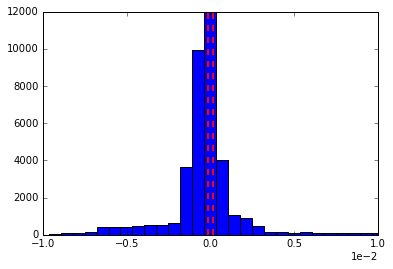

In [71]:
%matplotlib inline
plt.hist(dif_ra, align='left', bins=1000)
plt.ticklabel_format(style='sci', axis='x',scilimits=(0,0))
plt.axvline(0.00014, color='r', linestyle='dashed', linewidth=2)
plt.axvline(-0.00014, color='r', linestyle='dashed', linewidth=2)
plt.xlim((-0.01, 0.01))
plt.show()

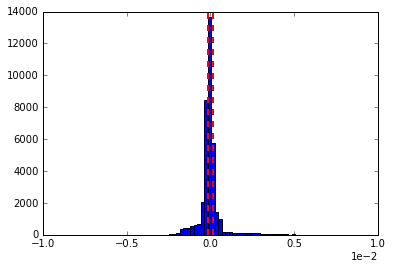

In [72]:
%matplotlib inline
plt.hist(dif_dec, align='left', bins=1000)
plt.ticklabel_format(style='sci', axis='x',scilimits=(0,0))
plt.axvline(0.00014, color='r', linestyle='dashed', linewidth=2)
plt.axvline(-0.00014, color='r', linestyle='dashed', linewidth=2)
plt.xlim((-0.01, 0.01))
plt.show()

In [3]:
visits = range(849373,849378)
visits.extend(range(849685,849690))
print visits

[849373, 849374, 849375, 849376, 849377, 849685, 849686, 849687, 849688, 849689]


In [4]:
calexps = []

for i in visits:
    
    cal = butler.get("calexp", dataId={"filter":filter, "visit":i, "ccd":14})
    #wcs = butler.get("wcs", dataId={"filter":filter, "visit":i, "ccd":14, "tract":0})
    #wcs = wcs.getWcs()
    #cal.setWcs(wcs)
    calexps.append(cal)




In [5]:
sources_catalog = []

#for calexp in calexps:
for visit in visits:
    sources_catalog.append(butler.get("src", dataId={"filter":filter, "visit":visit, "ccd":14}))
    
    #sources_catalog.append(detect_sources(calexp))

In [6]:
multi_matches = afwTable.MultiMatch(sources_catalog[0].schema, {'visit':'I'}, radius=afwGeom.Angle(1./3600., afwGeom.degrees))

In [7]:
for catalog, visit in zip(sources_catalog, visits):
    
    multi_matches.add(catalog, {'visit':visit})
    
results = multi_matches.finish(removeAmbiguous=False) 


In [5]:
def build_lightcurve(source_list, flux):
    """
    Assemble a light curve data table from available files.
    """

    bandpasses = ['r']


    lightcurve = {}
    #lightcurve['classification'] = []
    lightcurve['bandpass'] = []
    lightcurve['visit'] = []
    lightcurve['ra'] = []
    lightcurve['dec'] = []
    lightcurve['flux'] = []
    lightcurve['flux_error'] = []
    lightcurve['zp'] = []
    lightcurve['zpsys'] = []


    for src in source_list:
        
        #print 'yep',visit
        #lightcurve['classification'].append(src['classification_dipole'])
        lightcurve['bandpass'].append(str('sdss' + bandpasses[0]))
        
        lightcurve['visit'].append(src['visit'])
        lightcurve['ra'].append(float(src['coord_ra']))
        lightcurve['dec'].append(float(src['coord_dec']))
        lightcurve['flux'].append(src[flux])
        lightcurve['flux_error'].append(src[flux+'Sigma'])
        #lightcurve['flux'].append(src['base_CircularApertureFlux_12_0_flux'])
        #lightcurve['flux_error'].append(src['base_CircularApertureFlux_12_0_fluxSigma'])
        lightcurve['zp'].append(25.0)
        lightcurve['zpsys'].append('ab')
        #print lightcurve
    lightcurve = Table(data=lightcurve)
    return lightcurve

In [9]:
lcs = DSTools.get_light_curves_from_multimatch_results2(results)

In [10]:
t_lcs = DSTools.threshold_light_curves(lcs, 3)

In [11]:
f_lcs = []
for lc in t_lcs:
        f_lcs.append(build_lightcurve(lc, "base_CircularApertureFlux_4_5_flux"))
        

In [12]:

print len(f_lcs)

2886


In [36]:
std_ra = []
std_dec = []

for lc in f_lcs:
    std_ra.append(np.std(lc['ra']))
    std_dec.append(np.std(lc['dec']))

In [37]:
std_ra = np.multiply(std_ra,3600)
std_dec = np.multiply(std_dec,3600)

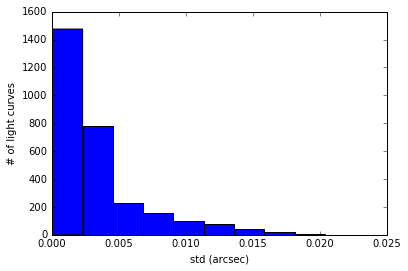

In [42]:
%matplotlib inline
plt.hist(std_ra)
plt.xlabel("std (arcsec)")
plt.ylabel("# of light curves")
#plt.ticklabel_format(style='sci', axis='x',scilimits=(0,0))
#plt.axvline(0.00003, color='r', linestyle='dashed', linewidth=2)
#plt.axvline(0.00014, color='r', linestyle='dashed', linewidth=2)
plt.show()

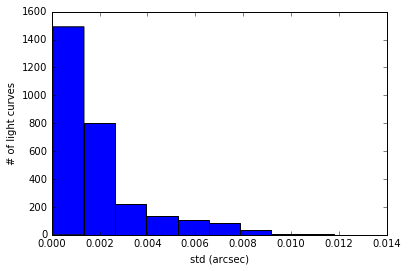

In [43]:
%matplotlib inline
plt.hist(std_dec)
plt.xlabel("std (arcsec)")
plt.ylabel("# of light curves")
#plt.ticklabel_format(style='sci', axis='x',scilimits=(0,0))
#plt.axvline(0.00003, color='r', linestyle='dashed', linewidth=2)
#plt.axvline(0.00014, color='r', linestyle='dashed', linewidth=2)
plt.show()

In [7]:
patches = []
patches_file=open(DATADIR+"/patches.txt", "rb")
for line in patches_file:
    line = line.replace('\n','')
    text = re.split("=| ",line)
    patches.append(text[-1])
patches_file.close()

In [51]:
dayCoadd = butler.get("dayCoadd", dataId={"filter":'r',"tract":0, "patch":"5,14", 'date':'2006-04-23'})
refCoadd = butler.get("deepCoadd", dataId={"filter":'r',"tract":0, "patch":"5,14"})

dayCoadd_sources=detect_sources(dayCoadd)
refCoadd_sources=detect_sources(refCoadd)

LengthError: 
  File "src/image/Image.cc", line 80, in static lsst::afw::image::ImageBase<PixelT>::_view_t lsst::afw::image::ImageBase<PixelT>::_makeSubView(const Extent2I&, const Extent2I&, const _view_t&) [with PixelT = double; lsst::afw::image::ImageBase<PixelT>::_view_t = boost::gil::image_view<boost::gil::memory_based_2d_locator<boost::gil::memory_based_step_iterator<boost::gil::pixel<double, boost::gil::layout<boost::mpl::vector1<boost::gil::gray_color_t> > >*> > >; lsst::afw::geom::Extent2I = lsst::afw::geom::Extent<int, 2>]
    Box2I(Point2I(7,-5),Extent2I(19,19)) doesn't fit in image 33x9 {0}
lsst::pex::exceptions::LengthError: 'Box2I(Point2I(7,-5),Extent2I(19,19)) doesn't fit in image 33x9'


In [90]:
count = 0
patches_bool = []
for patch in patches: 
    if butler.datasetExists("dayCoadd", dataId={"filter":'r',"tract":0, "patch":patch, 'date':'2006-04-23'}):
        patches_bool.append(True)
    else:
        patches_bool.append(False)

In [92]:
p = np.array(patches)
patches_bool = np.array(patches_bool)
p = p[patches_bool]

In [94]:
p_sub = np.random.choice(p, 100)
print p_sub

['17,9' '20,8' '10,20' '24,17' '6,15' '6,10' '22,15' '13,20' '15,10'
 '11,23' '23,10' '14,23' '15,16' '13,12' '15,13' '7,5' '12,13' '19,8'
 '7,12' '17,8' '15,15' '15,21' '18,16' '23,7' '8,15' '12,20' '11,16'
 '15,10' '9,13' '13,21' '18,10' '7,18' '17,7' '22,12' '18,8' '11,20'
 '19,19' '7,23' '14,17' '24,18' '17,12' '10,16' '20,10' '14,5' '12,5'
 '9,15' '16,15' '24,7' '8,12' '21,5' '18,23' '19,9' '22,16' '23,21' '14,15'
 '12,8' '20,21' '6,20' '24,19' '14,6' '20,14' '18,24' '13,5' '6,21' '7,6'
 '10,10' '22,24' '8,21' '6,19' '15,13' '16,6' '16,15' '19,8' '11,16'
 '13,24' '11,21' '15,6' '7,19' '10,8' '7,24' '11,22' '19,6' '24,19' '13,7'
 '23,16' '21,8' '15,10' '10,5' '19,14' '5,17' '21,9' '22,15' '5,18' '15,8'
 '12,12' '6,7' '13,12' '16,5' '16,10' '16,11']


In [95]:
dayCoadd_sources = None
refCoadd_sources = None
for patch in p_sub: 
    if butler.datasetExists("dayCoadd", dataId={"filter":'r',"tract":0, "patch":patch, 'date':'2006-04-23'}) and butler.datasetExists("deepCoadd", dataId={"filter":'r',"tract":0, "patch":patch}):
            try:
                dayCoadd = butler.get("dayCoadd", dataId={"filter":'r',"tract":0, "patch":patch, 'date':'2006-04-23'})
                refCoadd = butler.get("deepCoadd", dataId={"filter":'r',"tract":0, "patch":patch})

                if dayCoadd_sources is None:
                    refCoadd_sources=detect_sources(refCoadd)
                    dayCoadd_sources=detect_sources(dayCoadd)

                else:
                    refCoadd_sources.extend(detect_sources(refCoadd))
                    dayCoadd_sources.extend(detect_sources(dayCoadd))
            except Exception, e:
                print e
                pass
                
           
        

In [96]:
multi_matches = afwTable.MultiMatch(dayCoadd_sources.schema, {'visit':'I'}, radius=afwGeom.Angle(1./3600., afwGeom.degrees))


    
multi_matches.add(dayCoadd_sources, {'visit':0})
multi_matches.add(refCoadd_sources, {'visit':1})
    
results = multi_matches.finish(removeAmbiguous=False) 


In [97]:
lcs = DSTools.get_light_curves_from_multimatch_results2(results)
t_lcs = DSTools.threshold_light_curves(lcs, 2)
f_lcs = []
for lc in t_lcs:
        f_lcs.append(build_lightcurve(lc, "base_CircularApertureFlux_4_5_flux"))
        

In [98]:
diff_ra = []
diff_dec = []

for lc in f_lcs:
    diff_ra.append(lc[0]["ra"]-lc[1]["ra"])
    diff_dec.append(lc[0]["dec"]-lc[1]["dec"])
diff_ra = np.multiply(diff_ra,3600)
diff_dec = np.multiply(diff_dec,3600)

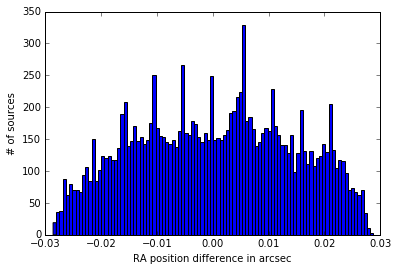

In [99]:

plt.hist(diff_ra, bins = 100) 
plt.xlabel("RA position difference in arcsec")
plt.ylabel("# of sources")
#plt.ticklabel_format(style='sci', axis='x',scilimits=(0,0))
plt.show()

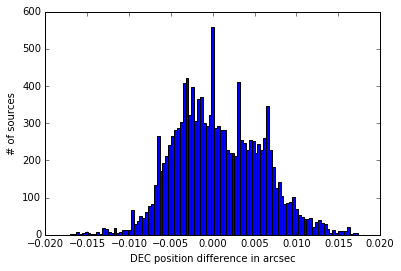

In [100]:
plt.hist(diff_dec, bins = 100)    
plt.xlabel("DEC position difference in arcsec")
plt.ylabel("# of sources")
#plt.ticklabel_format(style='sci', axis='x',scilimits=(0,0))
plt.show()

In [51]:
patch = patches[205]
if butler.datasetExists("dayCoadd", dataId={"filter":'r',"tract":0, "patch":patch, 'date':'2006-04-23'}) and butler.datasetExists("deepCoadd", dataId={"filter":'r',"tract":0, "patch":patch}):
        print "exists"
        dayCoadd = butler.get("dayCoadd", dataId={"filter":'r',"tract":0, "patch":patch, 'date':'2006-04-23'})
        dayCoaddArray = dayCoadd.getMaskedImage().getImage().getArray()
        refCoadd = butler.get("deepCoadd", dataId={"filter":'r',"tract":0, "patch":patch})
        refCoaddArray = refCoadd.getMaskedImage().getImage().getArray()
               

exists


In [89]:
patch = patches[205]
print patch

9,20


In [52]:
diffArray = dayCoaddArray - refCoaddArray

imageF = afwImage.ImageF(diffArray)
ds9.mtv(imageF)

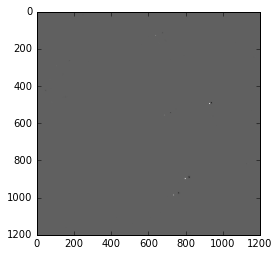

In [61]:

ds9.mtv(dayCoadd)

In [86]:

ds9.mtv(dayCoadd, frame=1)
#cImage = preConvolve(dayCoadd)
ds9.mtv(refCoadd, frame=2)


In [79]:
exp = afwImage.ExposureF()
exp.setMaskedImage(cImage)
exp.setPsf(dayCoadd.getPsf())

In [80]:
detect_sources(exp)